# CropAI_Training_Notebook
This script trains a MobileNetV2-based deep learning model to classify crop diseases using leaf images. It uses TensorFlow and Keras for model building, with support for training visualization and model checkpointing.


##  Dataset Class Labels

The dataset includes images of diseased and healthy leaves from three major crops: maize, tomato, and beans. Each subfolder represents one class.

| Maize               | Tomato                   | Beans               |
|---------------------|---------------------------|----------------------|
| healthy             | healthy                   | healthy              |
| blight              | bacterial_spot            | bean_rust            |
| gray_leaf_spot      | early_blight              | angular_leaf_spot    |
| rust                | late_blight               | anthracnose          |
| common_rust         | leaf_mold                 | mosaic_virus         |
| downy_mildew        | mosaic_virus              |                      |
| streak_virus        | target_spot               |                      |
| lethal_necrosis     | yellow_leaf_curl          |                      |
|                     | septoria_leaf_spot        |                      |
|                     | spider_mites              |                      |


## Imports
Import all necessary Python libraries for data loading, preprocessing, model building, evaluation, and visualization.



In [7]:
# General utilities
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


## Configuration & Setup
Set key constants like image size, batch size, and directory paths. Also ensure required directories exist for saving outputs and checkpoints.

In [8]:
from pathlib import Path

# Image settings
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

# Dataset paths
DATA_DIR = r"C:\Users\akech\Desktop\cropAI\data\raw"
PROCESSED_DIR = r"C:\Users\akech\Desktop\cropAI\data\processed"
TRAIN_DIR = os.path.join(PROCESSED_DIR, 'train')
VAL_DIR = os.path.join(PROCESSED_DIR, 'val')
TEST_DIR = os.path.join(PROCESSED_DIR, 'test')

# Model and asset paths
MODEL_PATH = r"C:\Users\akech\Desktop\cropAI\src\model\mobilenetv2_cropai.keras"
PLOT_PATH = r"C:\Users\akech\Desktop\cropAI\assets\training_outputs\training_plot.png"
SUMMARY_PATH = r"C:\Users\akech\Desktop\cropAI\assets\training_outputs\model_summary.txt"
HISTORY_PATH = r"C:\Users\akech\Desktop\cropAI\assets\training_outputs\training_history.csv"
EVAL_DIR = r"C:\Users\akech\Desktop\cropAI\assets\evaluation_outputs"
CONFUSION_PATH = os.path.join(EVAL_DIR, "confusion_matrix.png")

# Create required directories
Path(os.path.dirname(MODEL_PATH)).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(PLOT_PATH)).mkdir(parents=True, exist_ok=True)
Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)

# Confirm data availability
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
if os.path.exists(DATA_DIR):
    print("Found crops:", os.listdir(DATA_DIR))
else:
    print("DATA_DIR not found. Check the path.")


DATA_DIR exists: True
Found crops: ['beans', 'maize', 'tomato']


## Dataset Split Function
Define a function to automatically split each class into training and validation subsets

In [9]:
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    """
    Splits each class folder in source_dir into train, val, and test sets.
    """
    test_ratio = 1.0 - train_ratio - val_ratio
    assert test_ratio >= 0, "Invalid split ratios."

    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        src_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        for split_name, split_images in [('train', images[:train_end]), ('val', images[train_end:val_end]), ('test', images[val_end:])]:
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.copy2(os.path.join(src_path, img), os.path.join(split_dir, img))


In [10]:
# Ensure processed directory exists
Path(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

# Split dataset for each crop
for crop in ['maize', 'tomato', 'beans']:
    crop_path = os.path.join(DATA_DIR, crop)
    if os.path.exists(crop_path):
        split_dataset(crop_path, PROCESSED_DIR)
    else:
        print(f"Skipped: {crop_path} does not exist.")


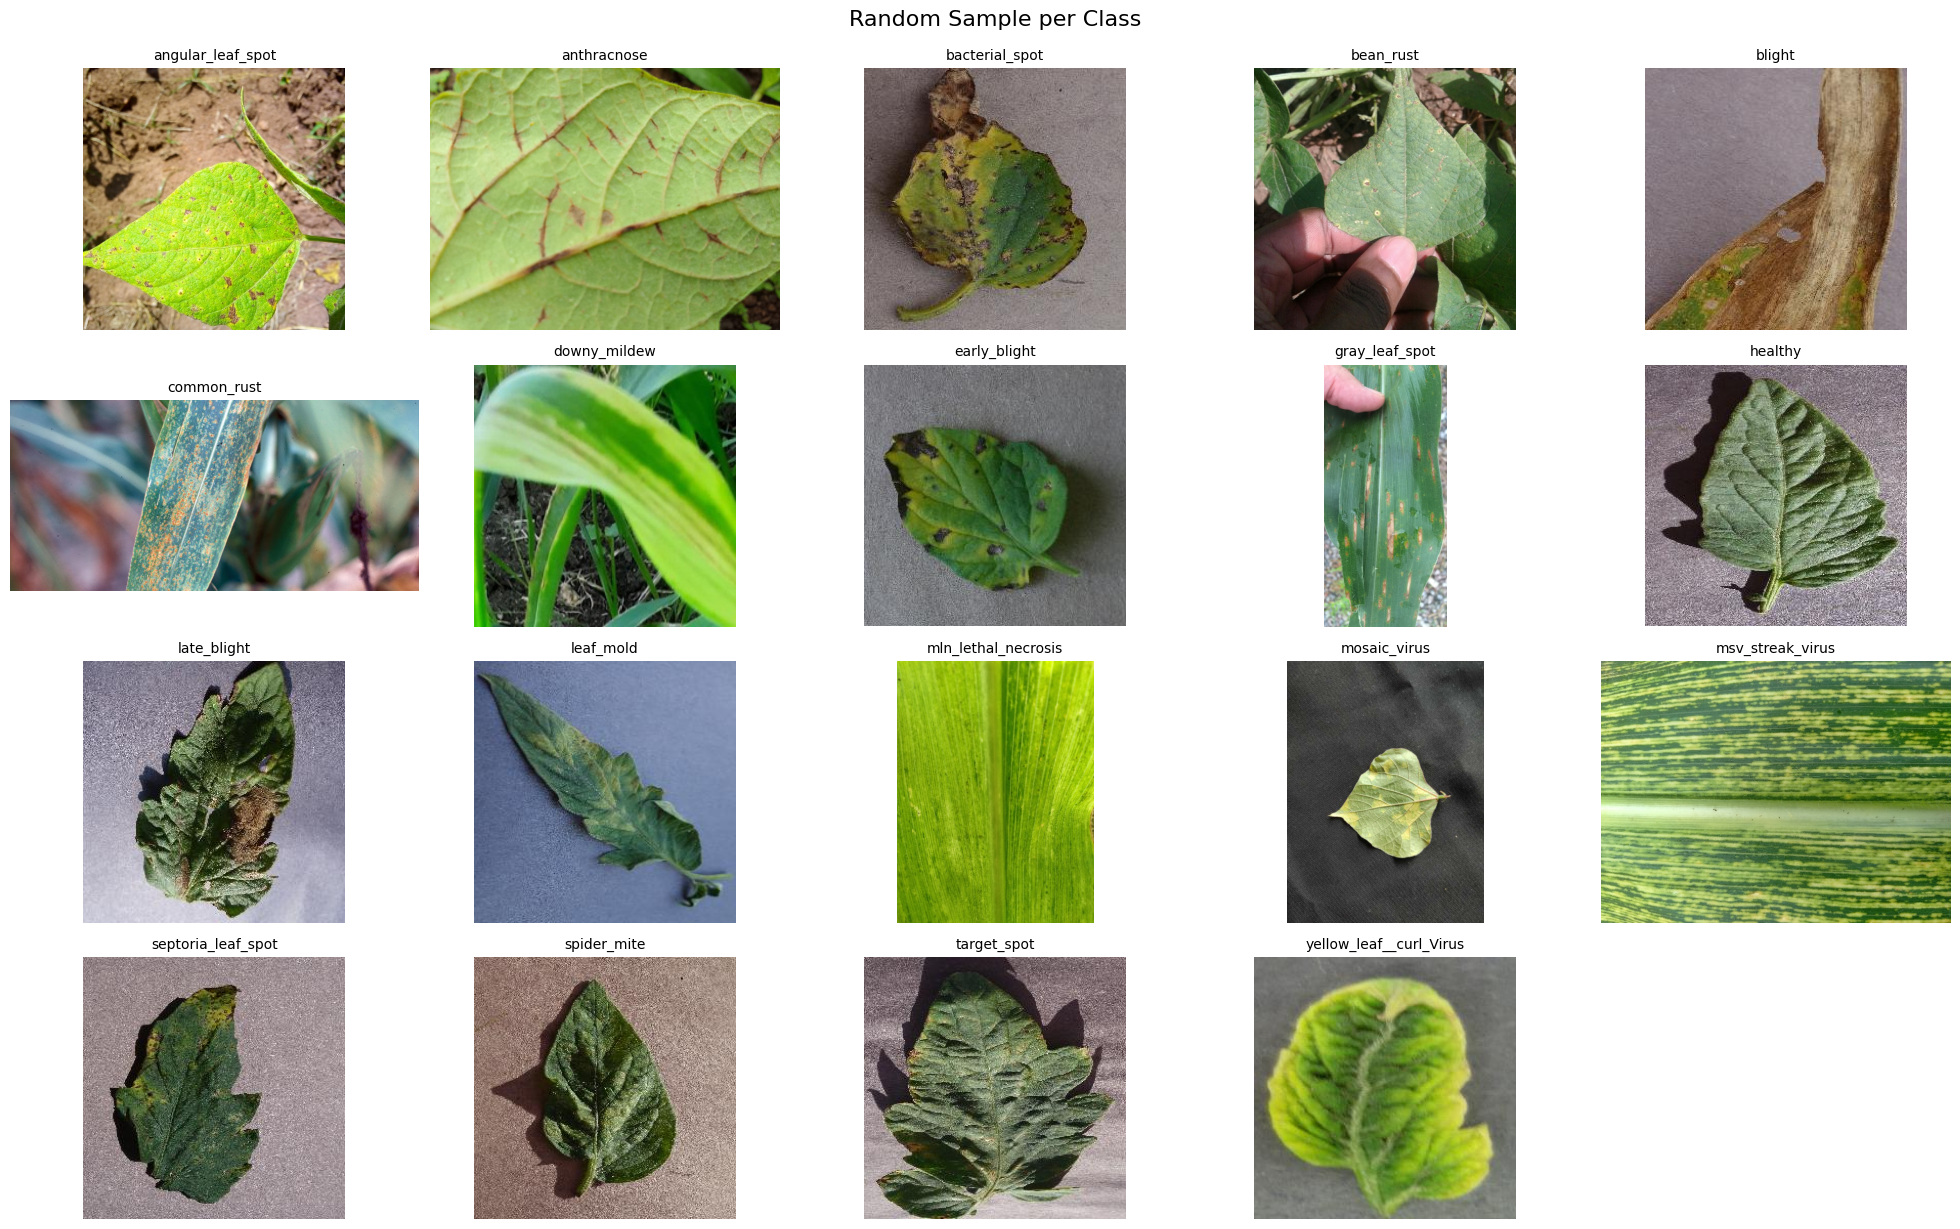

In [11]:
train_root = os.path.join(PROCESSED_DIR, "train")
image_paths, labels = [], []

for label in sorted(os.listdir(train_root)):
    class_dir = os.path.join(train_root, label)
    if os.path.isdir(class_dir):
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            chosen = random.choice(images)
            image_paths.append(os.path.join(class_dir, chosen))
            labels.append(label)

# Plotting
df_samples = pd.DataFrame({"image": image_paths, "label": labels})
cols = 5
rows = (len(df_samples) // cols) + 1
plt.figure(figsize=(cols * 4, rows * 3))

for i, row in enumerate(df_samples.itertuples(), 1):
    img = mpimg.imread(row.image)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(row.label, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Random Sample per Class", fontsize=16, y=1.02)
plt.show()


## Prepare Data Loaders
Use ImageDataGenerator to apply real-time augmentation and normalization. Load training and validation data from directory structure.|

In [12]:
# Image augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 24654 images belonging to 19 classes.
Found 15724 images belonging to 19 classes.


 ## Monitor Class Distribution

## Compute Class Weights

In [7]:
# Compute class weights
class_names = sorted(train_generator.class_indices.keys())
sample_counts = [
    len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, class_name)) 
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    for class_name in class_names
]

# Build label array for weight computation
y_labels = [i for i, count in enumerate(sample_counts) for _ in range(count)]

# Compute balanced weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

print("Class Weights:")
for i, name in enumerate(class_names):
    print(f"  {name}: {class_weights[i]:.2f}")


Class Weights:
  angular_leaf_spot: 3.94
  anthracnose: 12.96
  bacterial_spot: 0.61
  bean_rust: 3.93
  blight: 1.13
  common_rust: 0.99
  downy_mildew: 2.59
  early_blight: 1.30
  gray_leaf_spot: 2.26
  healthy: 0.82
  late_blight: 0.68
  leaf_mold: 1.36
  mln_lethal_necrosis: 0.84
  mosaic_virus: 2.31
  msv_streak_virus: 0.43
  septoria_leaf_spot: 0.73
  spider_mite: 0.77
  target_spot: 0.91
  yellow_leaf__curl_Virus: 0.47


## Build and Compile Model

In [8]:
# Load base model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save model architecture summary (UTF-8 safe for Windows)
with open(SUMMARY_PATH, "w", encoding="utf-8") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))


## Train the Model


In [9]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


C:\Users\akech\anaconda3\envs\cropai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 1043s 1s/step - accuracy: 0.7179 - loss: 0.8928 - val_accuracy: 0.8516 - val_loss: 0.4236
Epoch 2/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 866s 1s/step - accuracy: 0.8779 - loss: 0.3535 - val_accuracy: 0.8838 - val_loss: 0.3274
Epoch 3/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.8956 - loss: 0.2939 - val_accuracy: 0.8881 - val_loss: 0.3229
Epoch 4/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 881s 1s/step - accuracy: 0.9049 - loss: 0.2702 - val_accuracy: 0.8993 - val_loss: 0.2869
Epoch 5/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 1220s 2s/step - accuracy: 0.9138 - loss: 0.2381 - val_accuracy: 0.8990 - val_loss: 0.2890
Epoch 6/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.9174 - loss: 0.2308 - val_accuracy: 0.8970 - val_loss: 0.2948
Epoch 7/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 6214s 8s/step - accuracy: 0.9272 - loss: 0.2081 - val_accuracy: 0.9133 - val_loss: 0.2459
Epoch 8/20
770/770 ━━━━━━━━━━━━━━━━━━━━ 1038s 1s/step - accuracy: 0.9280 - loss: 0.2029 - val

## Plot Accuracy & Loss
Visualize training and validation accuracy/loss curves. Save figures and logs to output folder

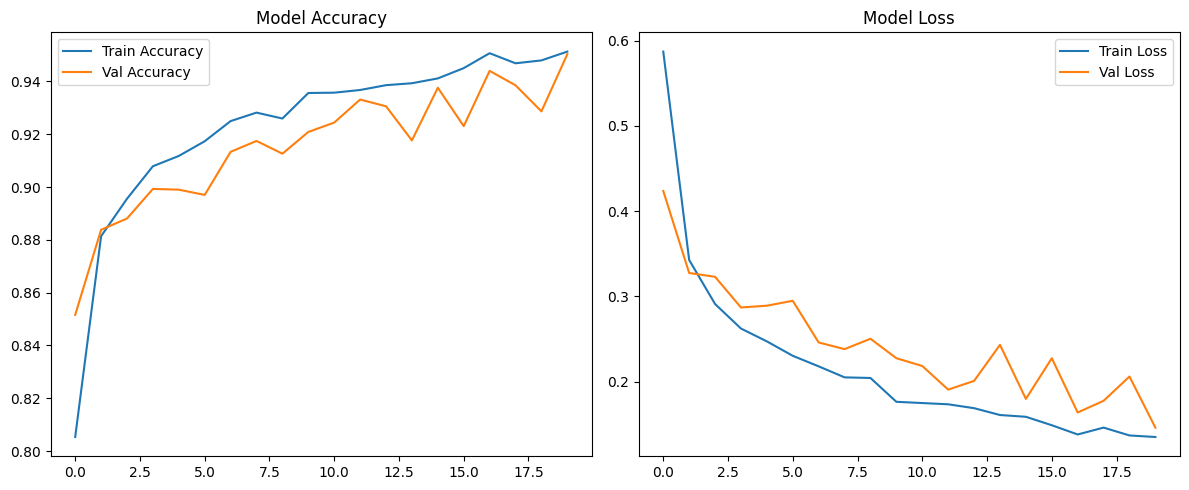

In [10]:
# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.legend()

plt.tight_layout()
plt.savefig(PLOT_PATH)
plt.show()

# Save training history
pd.DataFrame(history.history).to_csv(HISTORY_PATH, index=False)


# Evaluation Pipeline



##  Predict One Image (Top-3)

In [11]:
# Replace with any image from the test set
img_path = os.path.join(TEST_DIR, 'early_blight', 'early_blight0001.jpg')

# Preprocess single image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Reload the best saved model
model = load_model(MODEL_PATH)

# Predict
predictions = model.predict(img_array)[0]
top_3 = predictions.argsort()[-3:][::-1]

# Display results
print("Top-3 Predictions:")
for i in top_3:
    print(f"{class_names[i]}: {predictions[i]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top-3 Predictions:
early_blight: 99.64%
septoria_leaf_spot: 0.31%
target_spot: 0.04%


## Evaluation on Full Test Set

In [12]:
# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on the test set
loss, acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {acc * 100:.2f}%")

# Predictions and labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


Found 14145 images belonging to 19 classes.


C:\Users\akech\anaconda3\envs\cropai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 ━━━━━━━━━━━━━━━━━━━━ 321s 718ms/step - accuracy: 0.9524 - loss: 0.1358

 Test Accuracy: 94.85%
443/443 ━━━━━━━━━━━━━━━━━━━━ 299s 671ms/step


## Classification Report  & Confusion Matrix


443/443 ━━━━━━━━━━━━━━━━━━━━ 384s 866ms/step
Classification Report:
                         precision    recall  f1-score   support

      angular_leaf_spot       0.99      0.96      0.98       193
            anthracnose       1.00      1.00      1.00        54
         bacterial_spot       0.98      0.95      0.97      1194
              bean_rust       0.93      0.99      0.96       184
                 blight       0.94      0.93      0.93       643
            common_rust       0.97      0.99      0.98       740
           downy_mildew       1.00      0.98      0.99       277
           early_blight       0.85      0.87      0.86       539
         gray_leaf_spot       0.87      0.89      0.88       318
                healthy       0.93      0.96      0.95      1199
            late_blight       0.98      0.94      0.96      1075
              leaf_mold       0.94      0.95      0.95       515
    mln_lethal_necrosis       0.96      0.98      0.97       884
           mosaic_vir

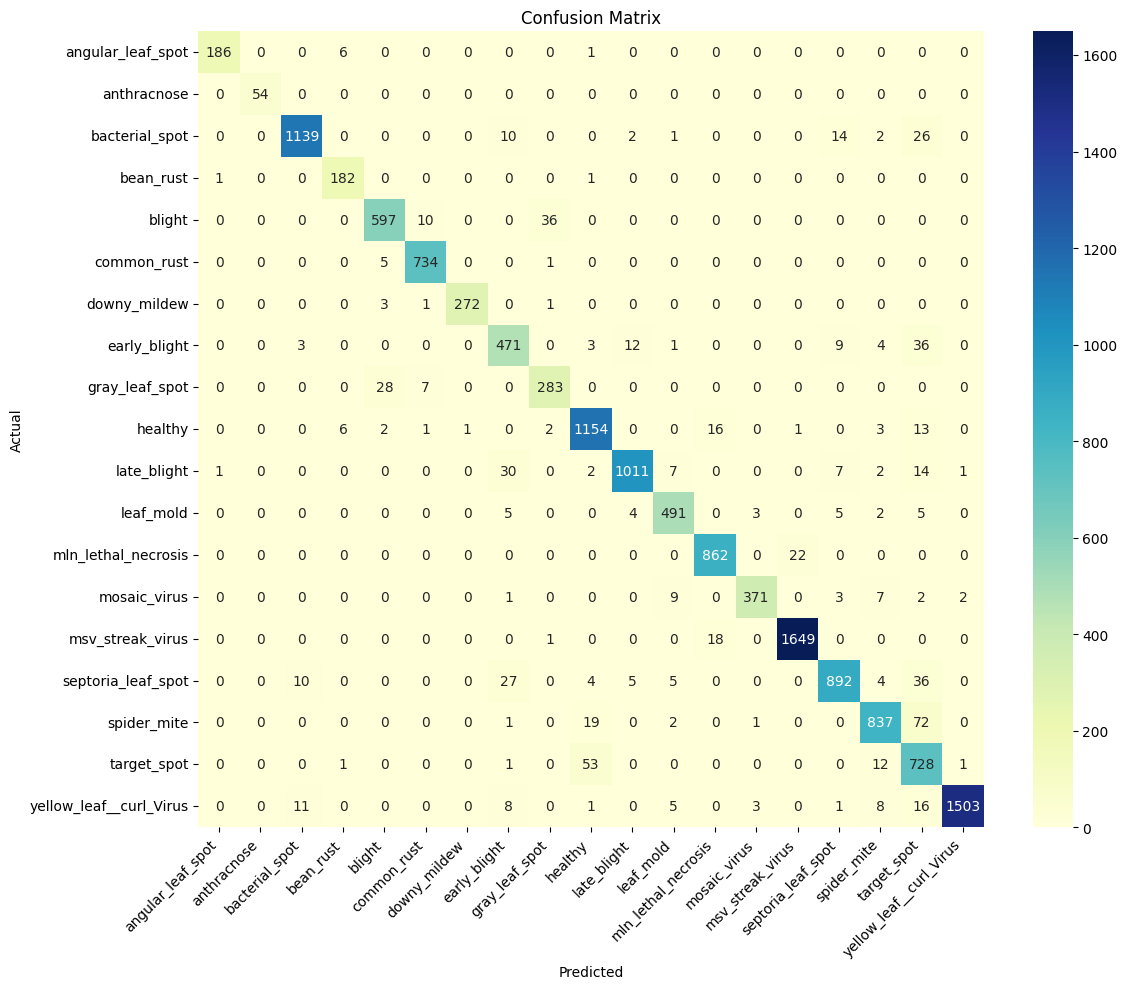

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use consistent evaluation path
CONFUSION_PATH = os.path.join(EVAL_DIR, "confusion_matrix.png")

# True labels and class names
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get predicted class indices from model
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(CONFUSION_PATH)
plt.show()


## Convert Model to TensorFlow Lite (TFLite)


In [3]:
import os
from pathlib import Path
import tensorflow as tf

# Define path to saved model
MODEL_PATH = r"C:\Users\akech\Desktop\cropAI\src\model\mobilenetv2_cropai.keras"


In [4]:
# Convert the model to TFLite
tflite_model_path = MODEL_PATH.replace('.keras', '.tflite')
model = tf.keras.models.load_model(MODEL_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved to:", tflite_model_path)


INFO:tensorflow:Assets written to: C:\Users\akech\AppData\Local\Temp\tmpefvco5ec\assets


INFO:tensorflow:Assets written to: C:\Users\akech\AppData\Local\Temp\tmpefvco5ec\assets


Saved artifact at 'C:\Users\akech\AppData\Local\Temp\tmpefvco5ec'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  1900632031472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632042384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632044496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632037808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632040096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632044320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632150912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632153024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632149152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1900632151264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19006

## Save Class Index Mapping

To ensure consistency during inference and API predictions, we export the class index-to-label mapping (as used during training) to a JSON file. This mapping will be loaded by the backend for decoding model predictions into readable labels.


In [14]:
import json

# Get class index ↔ label mapping from the training generator
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Define save path
CLASS_MAP_PATH = r"C:\Users\akech\Desktop\cropAI\src\model\class_indices.json"

# Save as JSON
with open(CLASS_MAP_PATH, 'w') as f:
    json.dump(index_to_class, f, indent=4)

print(f"Saved class mapping to: {CLASS_MAP_PATH}")


Saved class mapping to: C:\Users\akech\Desktop\cropAI\src\model\class_indices.json
